In [1]:
import numpy as np
import scipy.io
from math import isnan
import random

In [2]:
img_dirs = ['/pio/scratch/2/i258312/imdb_crop', '/pio/scratch/2/i258312/wiki_crop']
mat_files = ['/pio/scratch/2/i258312/imdb_crop/imdb.mat', '/pio/scratch/2/i258312/wiki_crop/wiki.mat']
set_names = ['imdb', 'wiki'] # 460k, 62k

In [3]:
hdf_path = '/pio/scratch/2/i258312/faces48px.hdf5'

In [4]:
# resizing parameters
size = 48
margin = int(0.25*size)
before_crop = size+2*margin

In [5]:
from scipy import misc

def read(base_dir, filename):
    im = misc.imread(base_dir+'/'+filename[0], mode='RGB')
    return im

In [6]:
from skimage.transform import resize
from skimage.util import crop

def smaller(im):
    im = resize(im, (before_crop, before_crop, 3), mode='edge')
    im = crop(im, ((margin, margin), (margin, margin), (0,0)))
    return im

In [7]:
import re
from datetime import date

def extract_age(filename, year_taken):
    filename = filename[0]
    match = re.search('(\d\d\d\d)-(\d+)-(\d+)',filename)
    if match:
        y = int(match.group(1))
        m = int(match.group(2))
        d = int(match.group(3))
        
        # some dates are broken
        try:
            born = date(y,m,d)
        except ValueError:
            #print(filename)
            try:
                born = date(y,m,15)
            except ValueError:
                born = date(y,7,15)
                
        taken = date(year_taken,7,1)
        return (taken - born).days / 365
    else:
        #print(filename)
        return None

In [8]:
img = []
sex = []
age = []
n = 0

In [9]:
# load the data
for (img_dir, mat, set_name) in zip(img_dirs, mat_files, set_names):
    # load metadata
    mat_data = scipy.io.loadmat(mat)
    data_table = mat_data[set_name][0][0]
    
    # extract info
    y = data_table[1][0,:]
    f = data_table[2][0,:]
    s = data_table[3][0,:]
    #names = data_table[4][0,:]
    #print(len(f))
    
    for (filename, year, curr_sex) in zip(f,y,s):
        # calculate age
        a = extract_age(filename, year)
        if (a is not None) and (a < 160) and (a >= 0):
            age.append(a)
        else:
            continue
    
        # load and resize image
        i = read(img_dir, filename)
        i = smaller(i)
        i = i.astype(np.float16)
        img.append(i)
        
        # get rid of nans in sex
        if isnan(curr_sex):
            curr_sex = random.choice([1.0, 0.0])
        curr_sex = bool(curr_sex)
        sex.append(curr_sex)
        
        n += 1
        if n % 5000 == 0:
            print(n)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000


In [10]:
n = len(img)
assert(len(sex) == len(age) == n)
n

520955

In [11]:
max(age)

159

In [13]:
img = np.array(img, dtype=np.float16).reshape(-1,size,size,3)
sex = np.array(sex, dtype=np.bool)
age = np.array(age, dtype=np.uint8)
img.shape

(520955, 48, 48, 3)

In [14]:
img.dtype

dtype('float16')

In [15]:
sex.shape

(520955,)

In [16]:
max(age)

159

In [17]:

age.shape

(520955,)

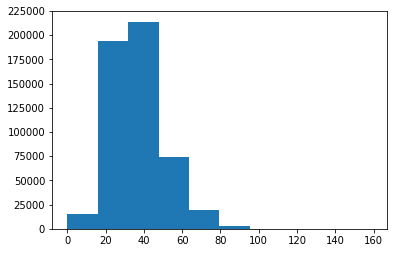

In [18]:
import matplotlib.pyplot as plt

plt.hist(age)
plt.show()

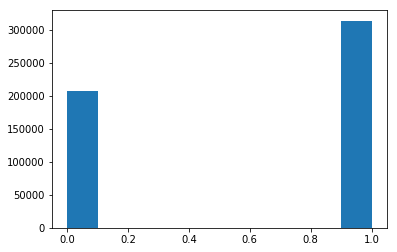

In [19]:
plt.hist(sex)
plt.show()

In [20]:
# save to hdf

import h5py

f = h5py.File(hdf_path, mode='w')
img_dset = f.create_dataset('img', data=img)
sex_dset = f.create_dataset('sex', data=sex)
age_dset = f.create_dataset('age', data=age)
f.flush()
f.close()

In [21]:
# read from hdf
f_read = h5py.File(hdf_path, mode='r')

img_read = f_read['img']
age_read = f_read['age']
sex_read = f_read['sex']
img_read.shape, age_read.shape, sex_read.shape

((520955, 48, 48, 3), (520955,), (520955,))

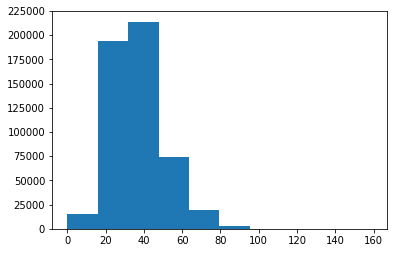

In [22]:
plt.hist(age_read)
plt.show()

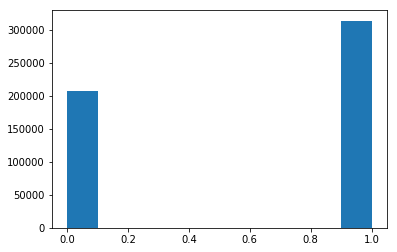

In [23]:
plt.hist(sex_read)
plt.show()

In [24]:
for i in [0,3,30,31,1000,1500,2000-1]:
    plt.imshow(img_read[i])
    plt.show()

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

In [26]:
f_read.flush()
f_read.close()

ValueError: Not a file or file object (Not a file or file object)